# Demo No. 11 - Radial velocities fitting.

The following two demos will illustrate how to solve an inverse problem in the case of the binary system with available radial velocities and photometric data. In this demo, we will focus on radial velocity fitting using a couple of optimization methods.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook
import numpy as np
import astropy.units as u

from elisa import settings
from elisa.analytics import RVData, RVBinaryAnalyticsTask


# setting up a custom logging config to prevent unreasonably long log messages during fit
settings.configure(LOG_CONFIG='fit')

As a start, we will create datasets containing observations of KIC 4851217 (Matson et al., 2017):

In [2]:
rv_primary = RVData.load_from_file('demo_data/rv_data/rv1.dat',  x_unit=u.d, y_unit=u.km/u.s)

rv_secondary = RVData.load_from_file('demo_data/rv_data/rv2.dat', x_unit=u.d, y_unit=u.km/u.s)

Let's finally define our starting parameters. Starting parameters are divided into `system`, `primary` and `secondary` categories. Model parameters are listed in the form of dictionaries that contain the name of the variable as a key. The corresponding values contain dictionaries characterizing starting value of the parameter, status of the parameter (`fixed`: True/False), the boundaries of the fitted parameter defined by `min`, `max` and the unit in astropy format:

In [3]:
rv_init_params = {
    'system':{
        'eccentricity': {
            'value': 0.03,
            'fixed': False,
            'min': 0.0,
            'max': 0.1
        },
        'asini': {
            'value': 12,
            'fixed': False,
            'min': 8.0,
            'max': 15,
            'unit': u.solRad
        },
        'mass_ratio': {
            'value': 1.0,
            'fixed': False,
            'min': 0.9,
            'max': 1.2
        },
        'argument_of_periastron': {
            'value': 170,
            'fixed': False,
            'min': 0,
            'max': 360,
            'unit': u.deg
        },
        'gamma': {
            'value': -25.0,
            'fixed': False,
            'min': -50.0,
            'max': -0.0,
            'unit': u.km/u.s
        },
        'period': {
            'value':2.47028,
            'fixed': True,
        },
        'primary_minimum_time': {
            'value': 54953.900507000006,
            'fixed': True,
            'unit': u.d
        }
    },
    'nuisance': {
        'ln_f': {
            'value': -5,
            'fixed': False,
            'min': -10,
            'max': 0,
            'unit': None
        }
    }
}

This set of parameters is listed in a format suitable for radial velocity fitting that uses parameters `system@asini`, `system@mass_ratio` instead of masses of the components (`primary@mass`, `secondary@mass`) and `system@inclination` parameter.

## Least squares method 

As a next step, we will create an `RVBinaryAnalyticsTask` upon which we will perform the fitting task itself utilizing the least squares method:

In [4]:
lst_sqr_task = RVBinaryAnalyticsTask(data={'primary': rv_primary, 'secondary': rv_secondary}, method='least_squares')

Before fitting itself, you can access valid fit parameter combinations in `standard` or `community` format: 

In [5]:
print(lst_sqr_task.FIT_PARAMS_COMBINATIONS)

{
    "community": {
        "system": [
            "mass_ratio",
            "asini",
            "eccentricity",
            "argument_of_periastron",
            "gamma",
            "period",
            "primary_minimum_time"
        ]
    },
    "standard": {
        "primary": [
            "mass"
        ],
        "secondary": [
            "mass"
        ],
        "system": [
            "inclination",
            "eccentricity",
            "argument_of_periastron",
            "gamma",
            "period",
            "primary_minimum_time"
        ]
    }
}


where nuisance parameter `ln_f` is used during the MCMC fit. We can finally start the fit itself using the following command (it will take a few seconds to complete):

In [6]:
lst_sqr_results = lst_sqr_task.fit(x0=rv_init_params)
lst_sqr_results

2021-06-17 10:06:20,038 - 8909 - analytics.binary_fit.least_squares - INFO: fitting radial velocity light curve...
2021-06-17 10:06:21,499 - 8909 - analytics.binary_fit.least_squares - INFO: fitting finished...
2021-06-17 10:06:21,502 - 8909 - analytics.binary_fit.rv_fit - INFO: Fitting and processing of results finished successfully.

------------------------------------------------------------------------------------------------------------------------------
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            1.077                   -                   -                None    Variable                                          
a*sin(i):                                          11.55          

{'system': {'eccentricity': {'value': 0.027038272557156646,
   'fixed': False,
   'unit': None,
   'min': 0.0,
   'max': 0.1},
  'argument_of_periastron': {'value': 207.99792708494553,
   'fixed': False,
   'unit': 'deg',
   'min': 0.0,
   'max': 360.0},
  'gamma': {'value': -24367.42200585189,
   'fixed': False,
   'unit': 'm / s',
   'min': -50000.0,
   'max': -0.0},
  'mass_ratio': {'value': 1.0773030912768242,
   'fixed': False,
   'unit': None,
   'min': 0.9,
   'max': 1.2},
  'asini': {'value': 11.546926546107361,
   'fixed': False,
   'unit': 'solRad',
   'min': 8.0,
   'max': 15.0},
  'period': {'value': 2.47028, 'fixed': True, 'unit': 'd'},
  'primary_minimum_time': {'value': 54953.900507000006,
   'fixed': True,
   'unit': 'd'}},
 'nuisance': {'ln_f': {'value': -5.0,
   'fixed': False,
   'unit': None,
   'min': -10,
   'max': 0}},
 'r_squared': {'value': 0.9931155766403489, 'unit': None}}

We can see that the function provided a summary of the fit (which can be now accessed via command `task.result_summary(filename=)`) and returned the results in the same form as the starting parameters.

Finally, we can visualize the resulting fit along with observations:

<IPython.core.display.Javascript object>


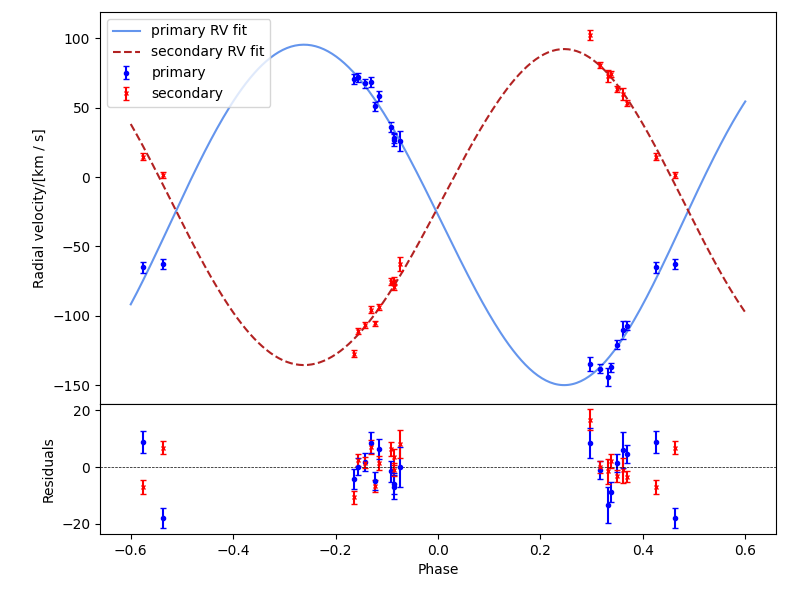

In [7]:
lst_sqr_task.plot.model()

We will now store the resulting parameters into the file that we will use later (parameters can be loaded using `lst_sqr_task.load_result(filename)`):

In [8]:
param_file = 'demo_data/assets/rv_lstsqr_params.json'
lst_sqr_task.save_result(param_file)

## Markov chain Monte Carlo (MCMC)

Using the MCMC, we can estimate confidence intervals of the fitted parameters, which was not possible in the least-squares method. Unfortunately, this capability is at the expense of speed and therefore, this method is meant to be used as a follow-up to the least-squares method. To speed up the initial burn-in phase, we will use the results obtained in the least-squares method as a starting parameter.

We have to create a new fitting task instance dedicated with the `mcmc` method specified: 

In [9]:
mcmc_task = RVBinaryAnalyticsTask(data={'primary': rv_primary, 'secondary': rv_secondary}, method='mcmc')

Updated starting parameters can now be used in a similar fashion to the least-squares method to perform MCMC sampling. Notice the `save` and `fit_id` parameter that is used to store fit results in Elisa `$HOME/mcmc_rv_fit/(fit_id).json`. You can also specify the full path to the file in `fit_id_parameter`:

In [10]:
my_fit_id = "mcmc_rv_fit"

In [11]:
mcmc_results = mcmc_task.fit(x0=lst_sqr_results, nwalkers=120, nsteps=120, burn_in=10, save=True, fit_id=my_fit_id, progress=True)
mcmc_results

2021-06-17 10:06:21,749 - 8909 - analytics.binary_fit.mcmc - INFO: starting mcmc
2021-06-17 10:06:21,749 - 8909 - analytics.binary_fit.mcmc - INFO: starting singlecore mcmc
2021-06-17 10:06:21,750 - 8909 - analytics.binary_fit.mixins - INFO: running burn-in...


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

2021-06-17 10:06:25,233 - 8909 - analytics.binary_fit.mixins - INFO: running production...



100%|██████████| 120/120 [00:34<00:00,  3.47it/s]

2021-06-17 10:06:59,973 - 8909 - analytics.binary_fit.mixins - INFO: MCMC chain, variable`s fitable and normalization constants were stored in: /home/miro/.elisa/mcmc_rv_fit/mcmc_rv_fit.json
2021-06-17 10:06:59,982 - 8909 - analytics.binary_fit.rv_fit - INFO: Fitting and processing of results finished successfully.

------------------------------------------------------------------------------------------------------------------------------
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                             1.08                0.05                0.03                None    Variable                                          
a*sin(i):                                           11.3                 0.3          

{'system': {'eccentricity': {'value': 0.03,
   'confidence_interval': {'min': 0.02, 'max': 0.05},
   'fixed': False,
   'min': 0.0,
   'max': 0.1,
   'unit': None},
  'argument_of_periastron': {'value': 228.0,
   'confidence_interval': {'min': 146.0, 'max': 256.0},
   'fixed': False,
   'min': 0.0,
   'max': 360.0,
   'unit': 'deg'},
  'gamma': {'value': -24700.0,
   'confidence_interval': {'min': -26800.0, 'max': -23100.0},
   'fixed': False,
   'min': -50000.0,
   'max': -0.0,
   'unit': 'm / s'},
  'mass_ratio': {'value': 1.08,
   'confidence_interval': {'min': 1.03, 'max': 1.11},
   'fixed': False,
   'min': 0.9,
   'max': 1.2,
   'unit': None},
  'asini': {'value': 11.3,
   'confidence_interval': {'min': 11.0, 'max': 11.7},
   'fixed': False,
   'min': 8.0,
   'max': 15.0,
   'unit': 'solRad'},
  'period': {'value': 2.47028, 'fixed': True, 'unit': 'd'},
  'primary_minimum_time': {'value': 54953.900507000006,
   'fixed': True,
   'unit': 'd'}},
 'nuisance': {'ln_f': {'value': -2.3,

We can inspect the results by examining a correlation diagrams in the corner plot:

<IPython.core.display.Javascript object>


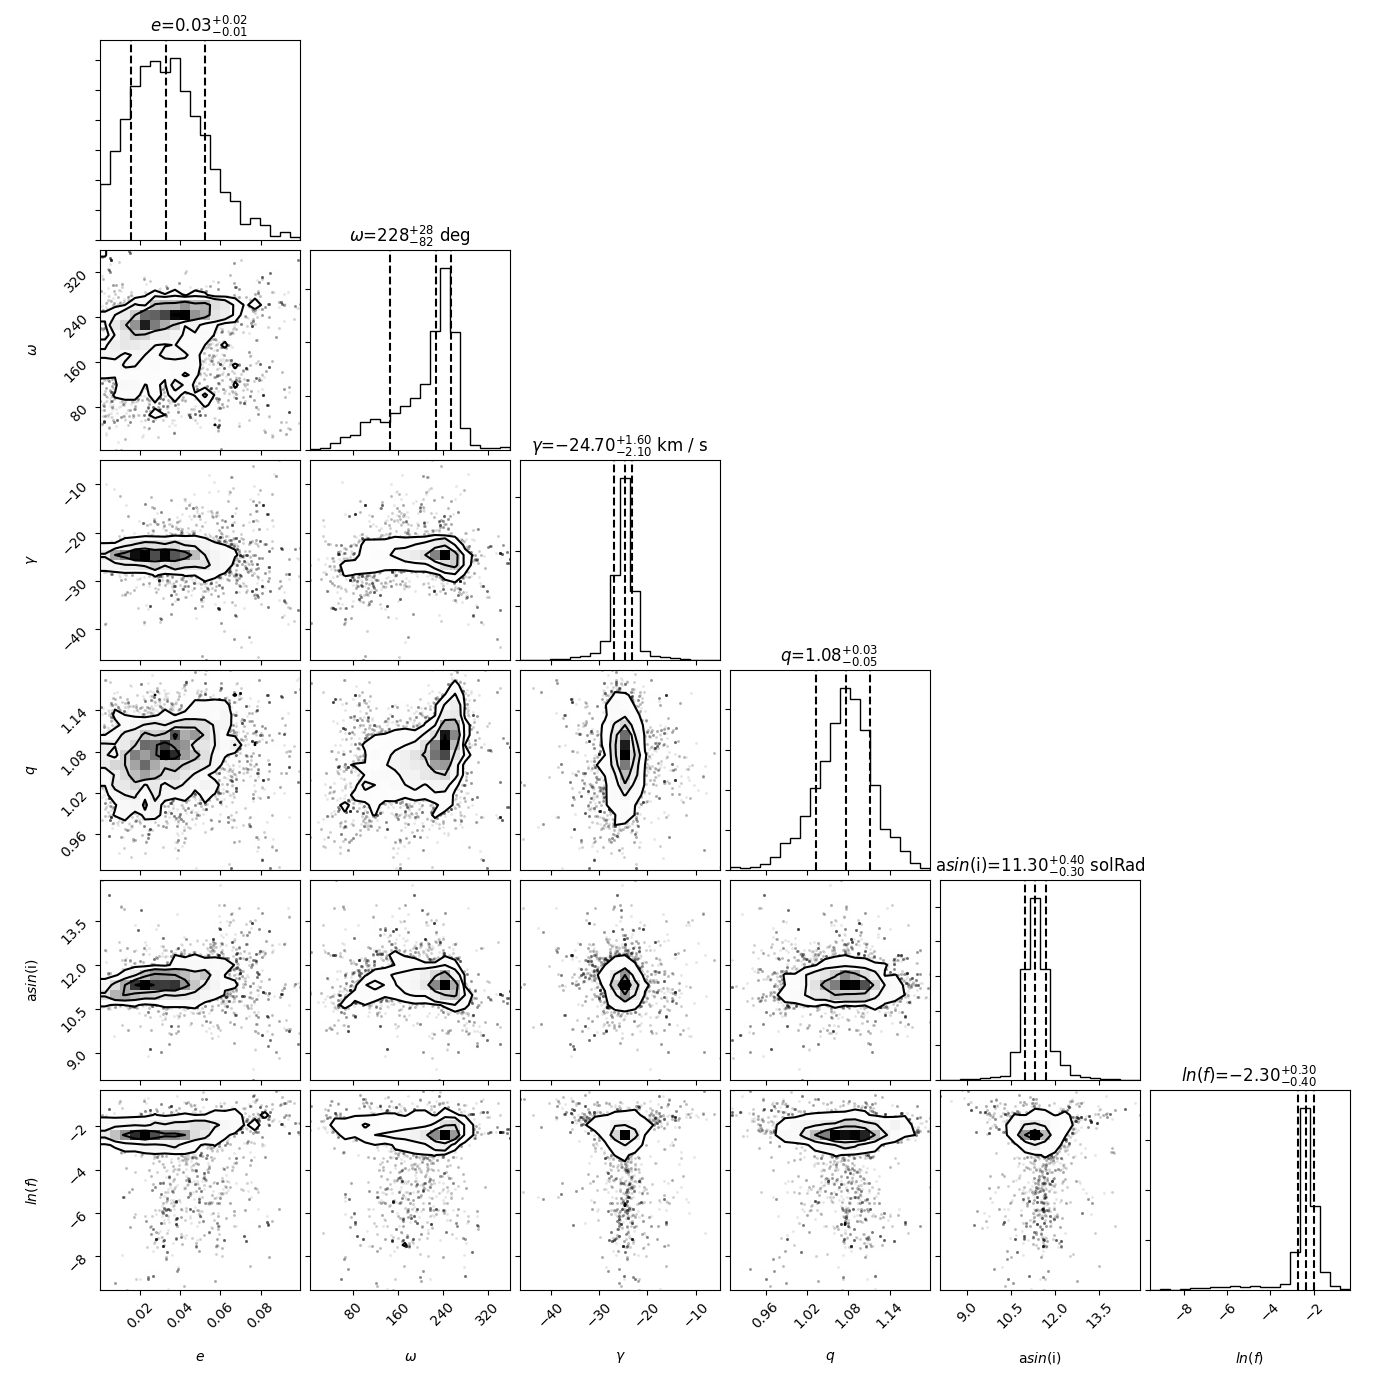

2021-06-17 10:07:01,253 - 8909 - root - WARNING: Too few points to create valid contours


In [12]:
mcmc_task.plot.corner()

Traces can be also investgated:

<IPython.core.display.Javascript object>


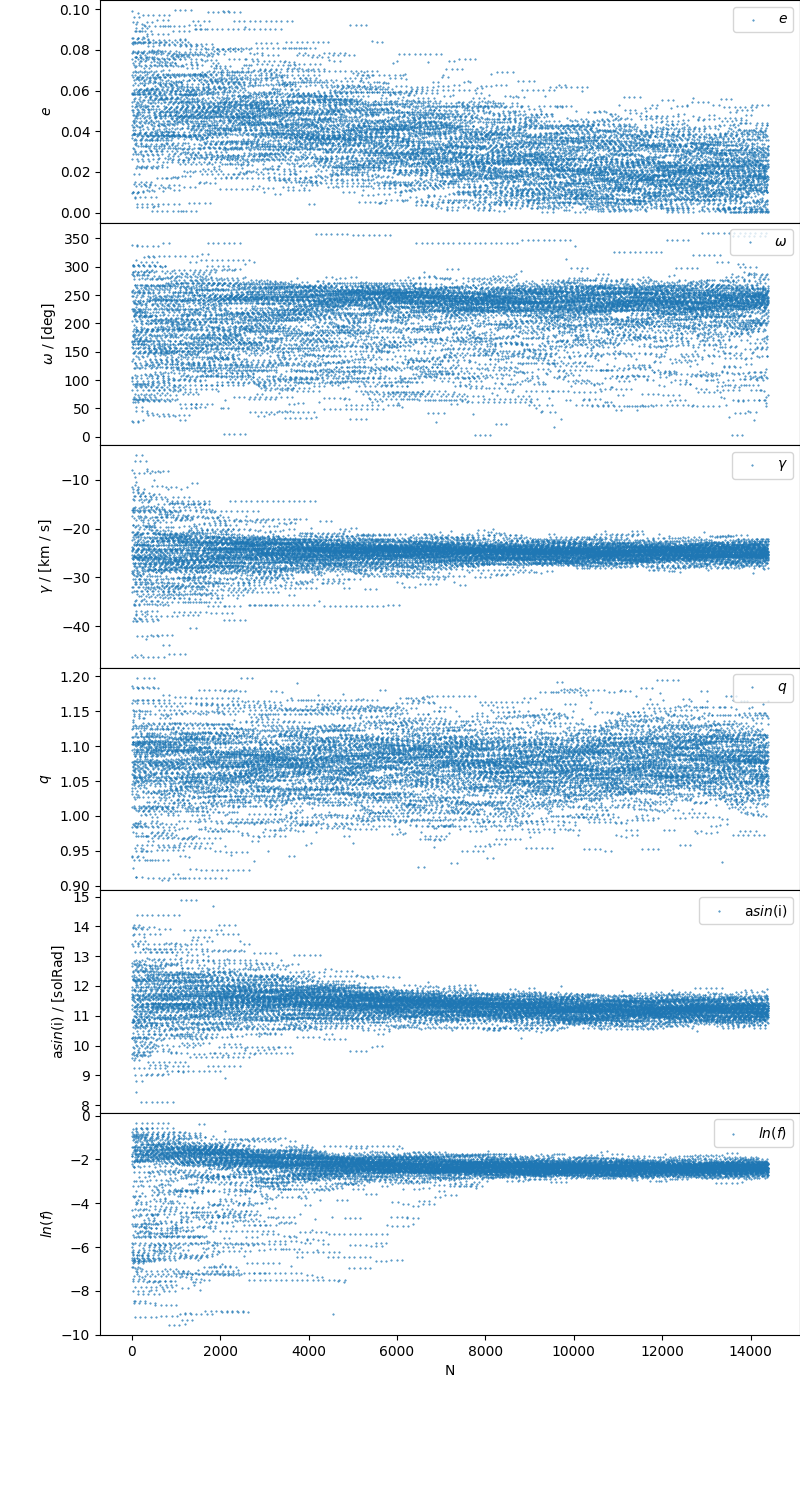

In [13]:
mcmc_task.plot.traces()

Along with autocorrelation function and autocorrelation times:

2021-06-17 10:07:01,700 - 8909 - root - WARNING: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 288;
tau: [1534.35075649]


<IPython.core.display.Javascript object>


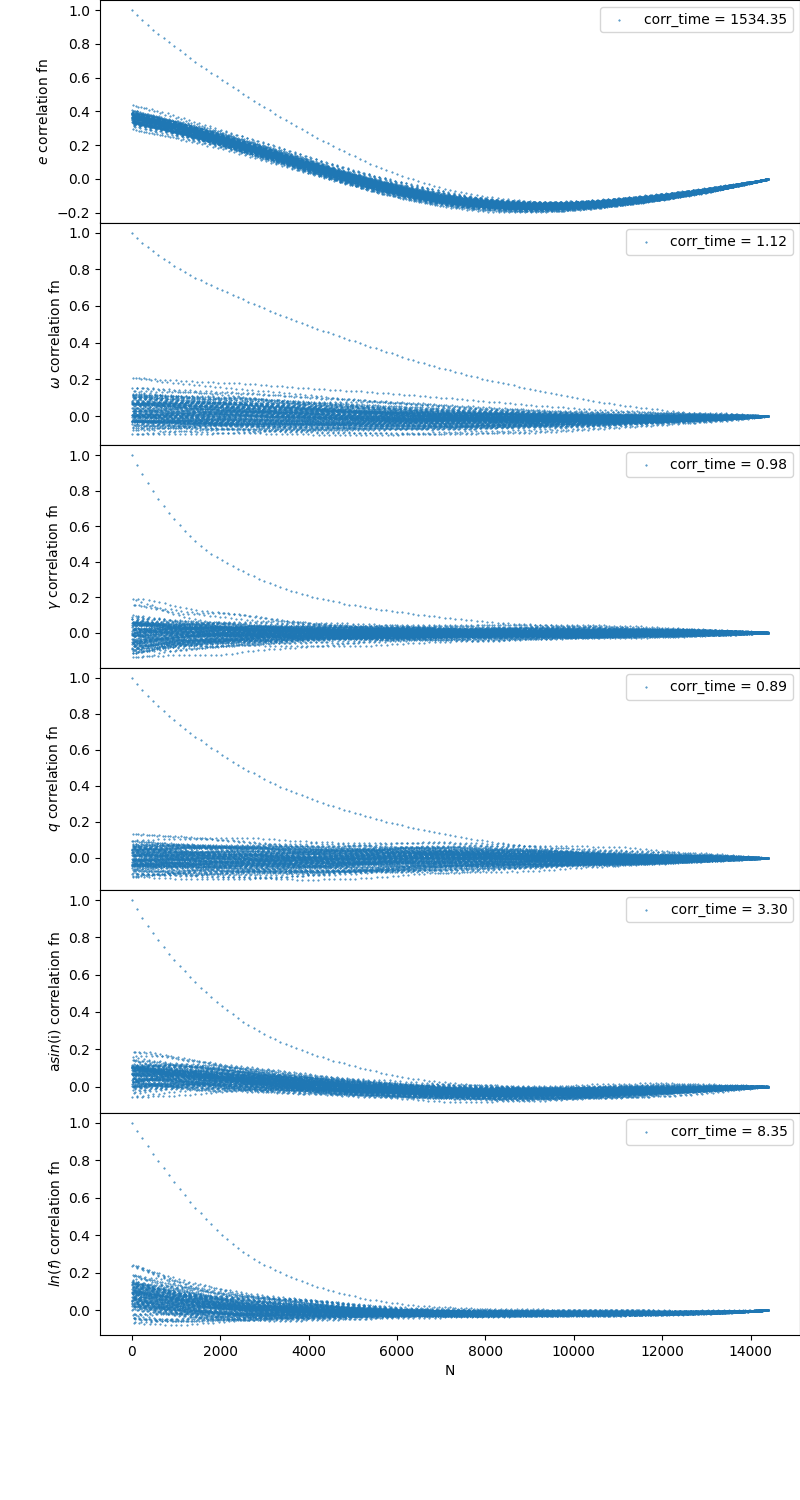

In [14]:
mcmc_task.plot.autocorrelation()

As you can (probably) see in this example, ten steps in the `burn_in` phase were not sufficient to de-correlate all of the chains. This can be remedied easily by increasing the number of iterations or by specifying a longer `burn_in` argument in the `fit` function.

Due to the fact that the MCMC method is a very time demanding method, the resulting chain can be recovered using your `fit_id` identification (or path), where you can use the `discard` parameter to filter out the thermalization stage of your chain:

In [15]:
mcmc_task.load_chain(my_fit_id, discard=8000)

We can use a modified chain to produce the more precise fit summary (where `filename` argument can be used to write the summary to file and 'propagate_errors' to do the complete error estimation of all model parameters):

In [16]:
mcmc_task.result_summary()


------------------------------------------------------------------------------------------------------------------------------
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                             1.08                0.04                0.03                None    Variable                                          
a*sin(i):                                           11.2                 0.2                 0.3              solRad    Variable                                          
Eccentricity (e):                                   0.02                0.01                0.02                None    Variable                                          
Argument of periastron (omega):                    233.0     

<IPython.core.display.Javascript object>


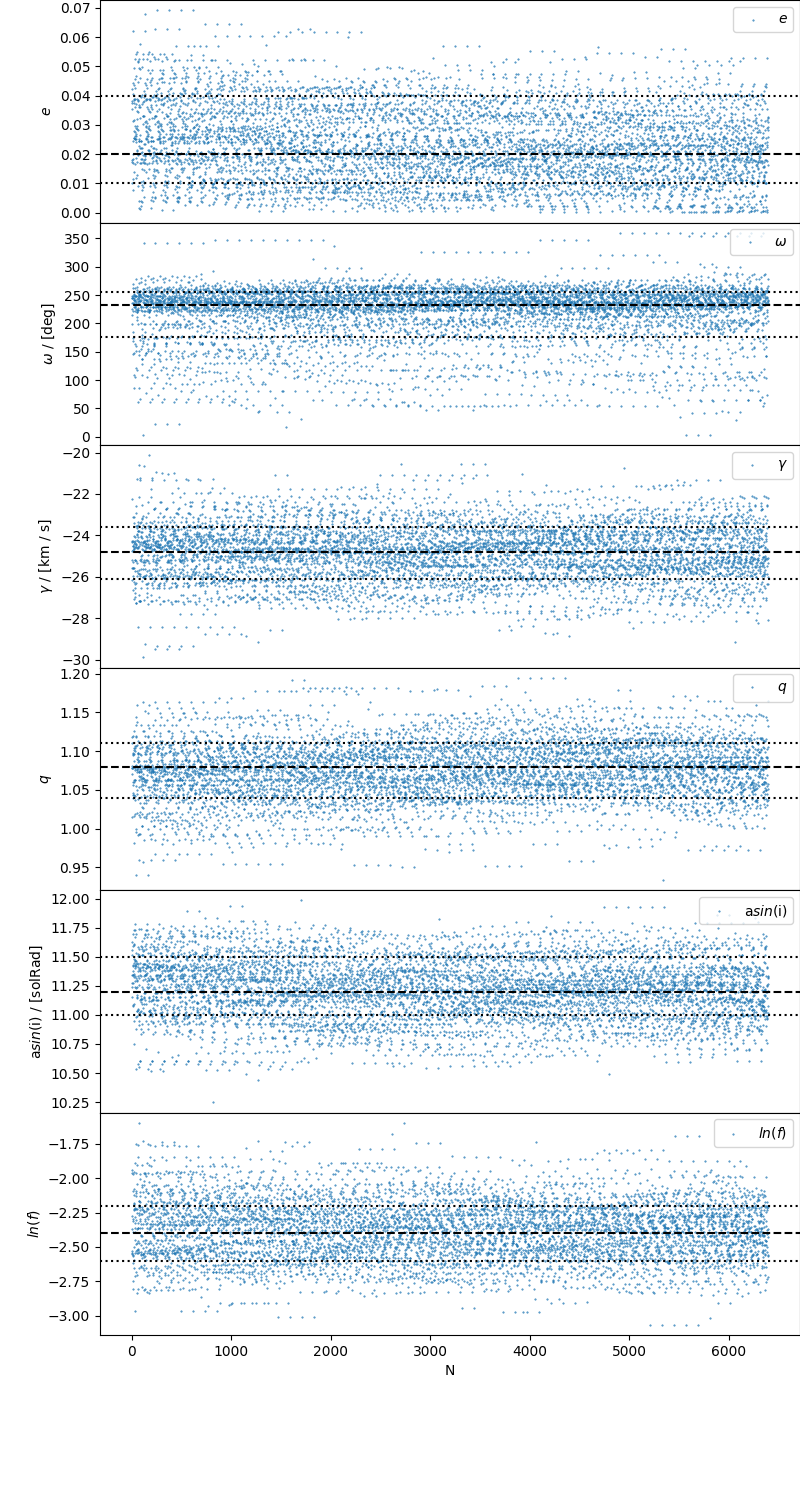

In [17]:
mcmc_task.plot.traces(truths=True)

## References:

Matson, R. A.; Gies, D. R.; Guo, Z.; Williams, S. J. 2017, AJ, 154, 6, 216